In [43]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
idx = pd.IndexSlice

In [2]:
!head -n2 data/H1.csv

IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,342,2015,July,27,1,0,0,2,0,0,BB       ,PRT,Direct,Direct,              0,0,0,C               ,C               ,3,No Deposit     ,       NULL,       NULL,0,Transient,0,0,0,Check-Out,2015-07-01


In [3]:
data = pd.read_csv('data/H1.csv')

data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40060 entries, 0 to 40059
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   40060 non-null  int64  
 1   LeadTime                     40060 non-null  int64  
 2   ArrivalDateYear              40060 non-null  int64  
 3   ArrivalDateMonth             40060 non-null  object 
 4   ArrivalDateWeekNumber        40060 non-null  int64  
 5   ArrivalDateDayOfMonth        40060 non-null  int64  
 6   StaysInWeekendNights         40060 non-null  int64  
 7   StaysInWeekNights            40060 non-null  int64  
 8   Adults                       40060 non-null  int64  
 9   Children                     40060 non-null  int64  
 10  Babies                       40060 non-null  int64  
 11  Meal                         40060 non-null  object 
 12  Country                      39596 non-null  object 
 13  MarketSegment   

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02


In [24]:
ts = data['IsCanceled']
ts.index = pd.to_datetime(
    (data['ArrivalDateYear'].astype(str)
     + '-'
     + data['ArrivalDateMonth']
     + '-'
     + data['ArrivalDateDayOfMonth'].astype(str))
)

ts.head(2)
ts.tail(2)

2015-07-01    0
2015-07-01    0
Name: IsCanceled, dtype: int64

2017-08-31    0
2017-08-31    0
Name: IsCanceled, dtype: int64

In [26]:
ts = ts.resample('W-MON').sum()

ts.head(2)
ts.tail(2)

2015-07-06    54
2015-07-13    56
Freq: W-MON, Name: IsCanceled, dtype: int64

2017-08-28    153
2017-09-04     42
Freq: W-MON, Name: IsCanceled, dtype: int64

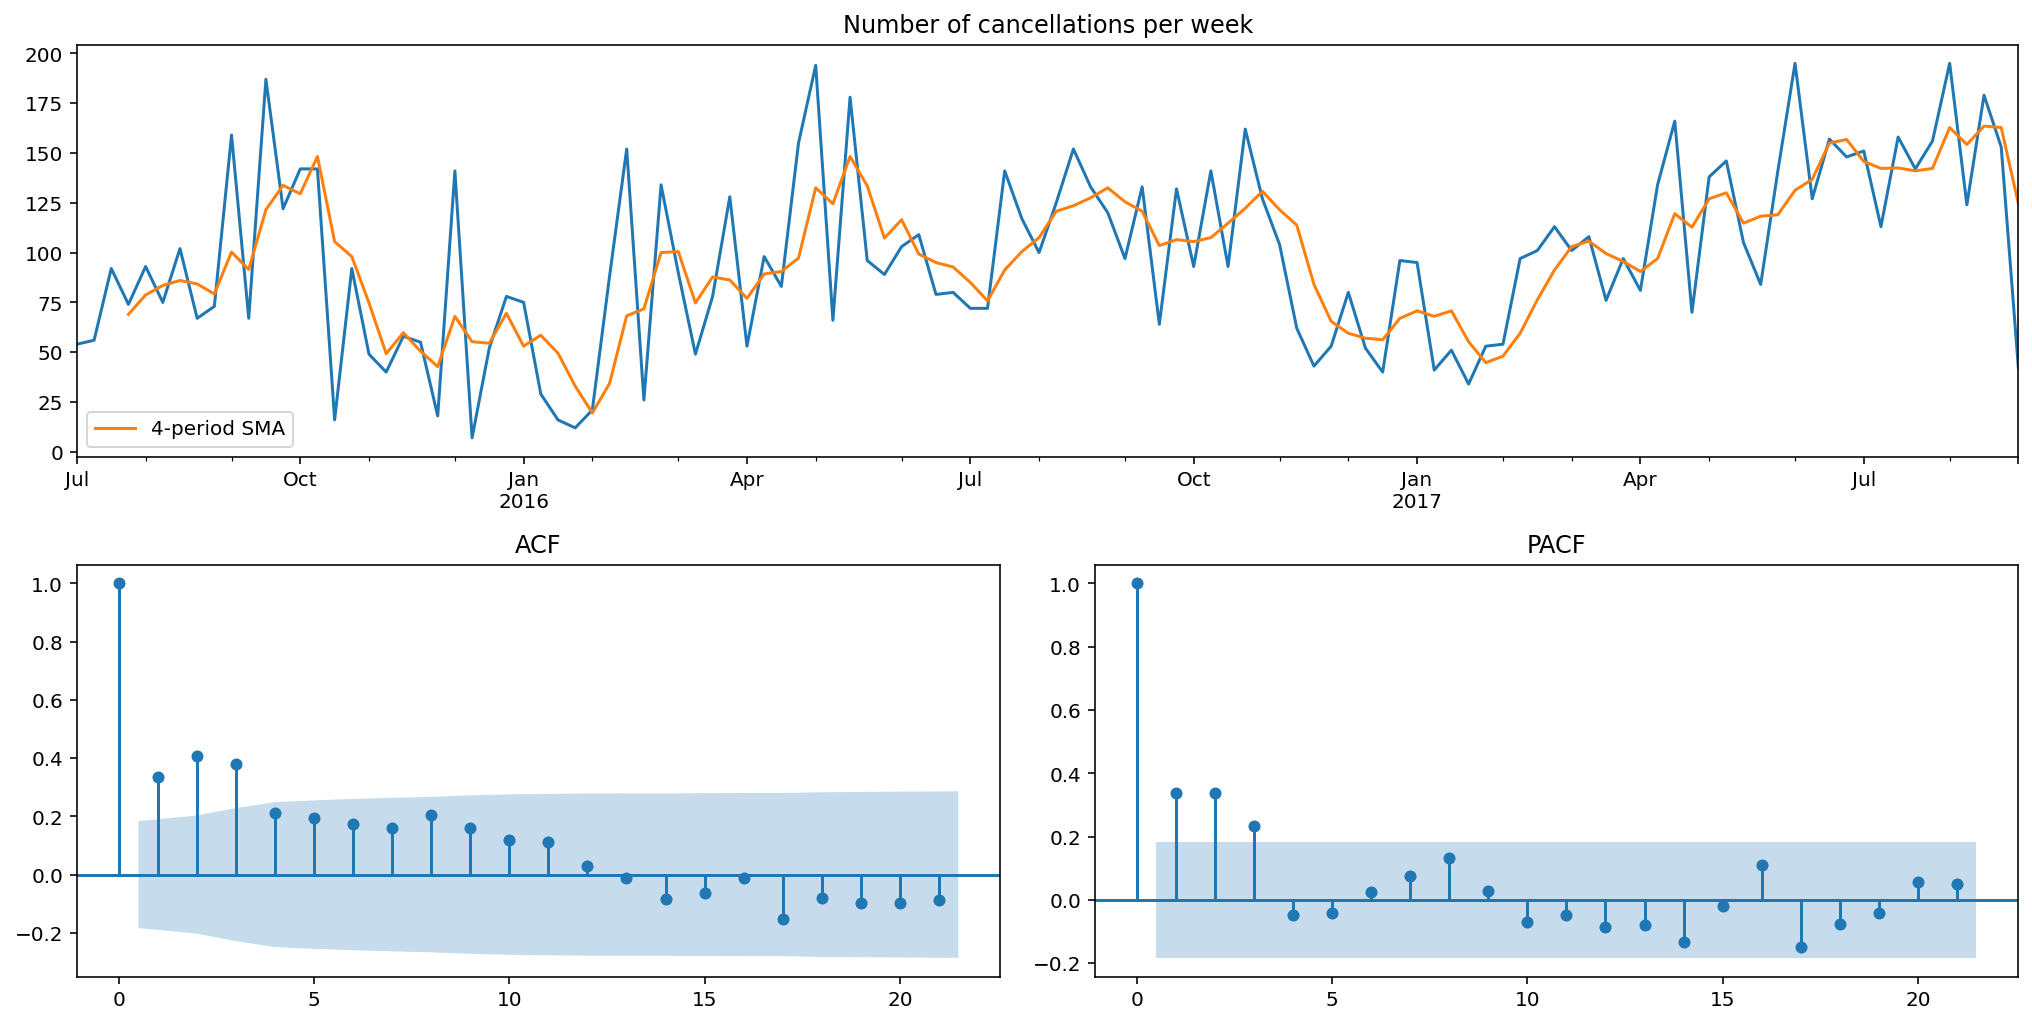

In [39]:
fig = plt.figure(constrained_layout=True, figsize=(14, 7))
gs = fig.add_gridspec(2, 2)

ax_top = fig.add_subplot(gs[0, :])
ax_bot_0 = fig.add_subplot(gs[1, 0])
ax_bot_1 = fig.add_subplot(gs[1, 1])

_ = ts.plot(ax=ax_top, title='Number of cancellations per week', label='')
_ = ts.rolling(window=4).mean().plot(ax=ax_top, label='4-period SMA')
_ = plot_acf(ts, ax=ax_bot_0, title='ACF')
_ = plot_pacf(ts, ax=ax_bot_1, title='PACF')

_ = ax_top.legend()

[seasonal_decompose](https://www.statsmodels.org/v0.12.0/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

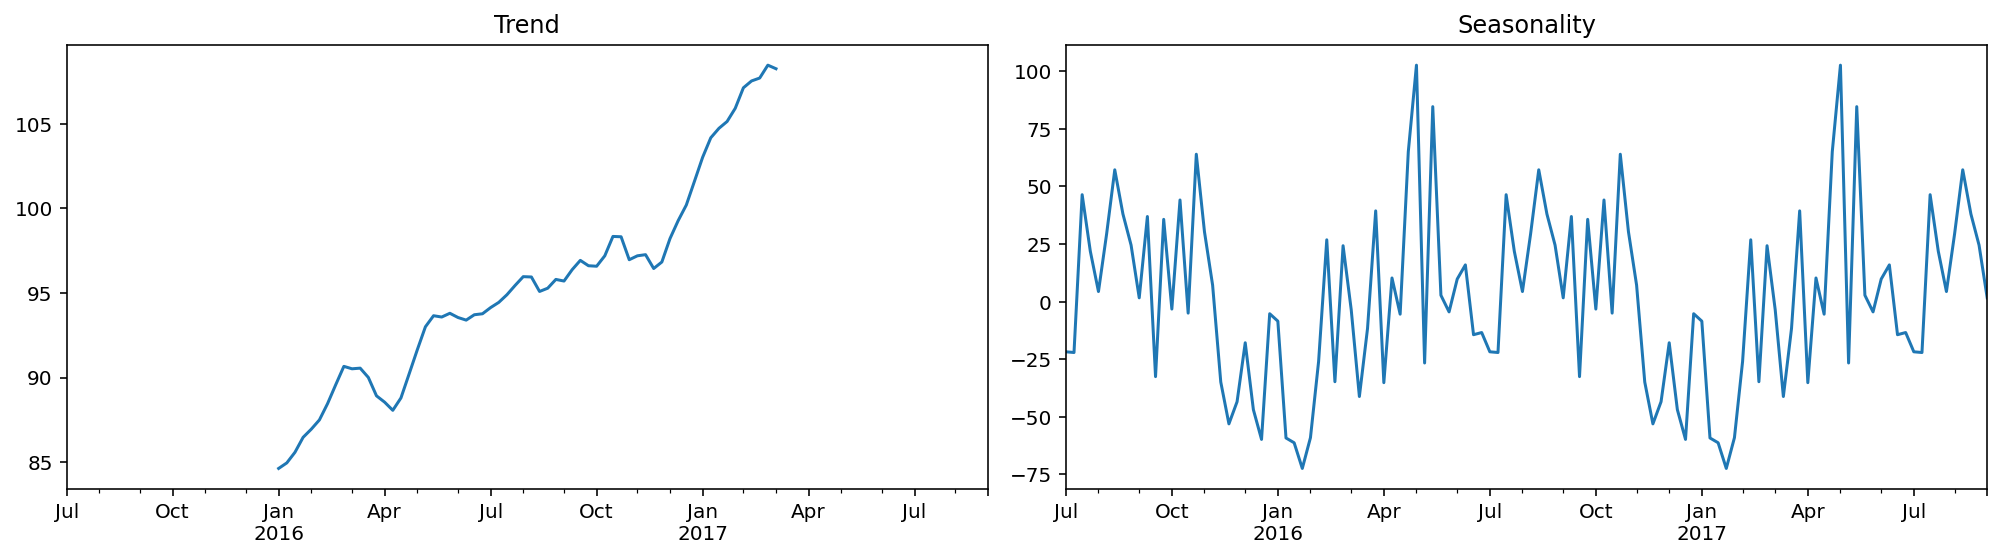

In [52]:
decomposition = seasonal_decompose(ts, period=52)

fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(14, 4))

_ = decomposition.trend.plot(ax=axs[0], title='Trend')
_ = decomposition.seasonal.plot(ax=axs[1], title='Seasonality')
# decomposition.resid

fig.tight_layout()

#### 90/10 train-test split

In [40]:
len(ts)
round(len(ts) * .9), len(ts) - round(len(ts) * .9) 

114

(103, 11)

In [42]:
train, test = ts.iloc[:103], ts.iloc[103:]

len(train), len(test)

(103, 11)